# MATH 497: Final Project

Remark: 

Please upload your solutions of this assignment to Canvas with a file named "Final_Project_yourname.ipynb".

=================================================================================================================

## Problem 1:  

Consider the following linear system

\begin{equation}\label{matrix}
A\ast u =f,
\end{equation}
or equivalently $u=\arg\min \frac{1}{2} (A* v,v)_F-(f,v)_F$, where $(f,v)_F =\sum\limits_{i,j=1}^{n}f_{i,j}v_{i,j} $.
Here $A\ast$ is a convolution for one channel with stride 1 and zero padding 1 
$$ 
A=\begin{bmatrix} 0 & -1 & 0 \\ -1 & 4 & -1 \\ 0 & -1 & 0 \end{bmatrix},~~
$$
 
$ u \in \mathbb{R}^{n\times n} $, $ f\in \mathbb{R}^{n\times n}$ and $f_{i,j}=\dfrac{1}{(n+1)^2}.$


### Requirement:
Set $J=4$, $n=2^J-1$ and the number of iteration $M=100$. Use gradient descent method  and multigrid method to solve the above problem with random initial guess $u^0$. The solution obtained by gradient descent method  and multigrid method are denoted by $u_{GD}$ and $u_{MG}$ respectively.

    
* Plot the surface of solution $u_{GD}$ and $u_{MG}$.

* Define error $e_{GD}^m = \|A * u^{m}_{GD}- f\|_F=\sqrt{\sum\limits_{i=1}^{n}\sum\limits_{j=1}^{n} |(A * u^{m}_{GD}- f)_{i,j}}|^2 $, $m=0,1,2,3,...,M$. Similarly we can define $e_{MG}^m$. Plot the curves of $e_{GD}^m$ and $e_{MG}^m$  in one figure.

* Find the minumum $m_1$ when  $e^{m_1}_{GD} <10^{-5}$ and the minumum $m_2$ when  $e^{m_2}_{MG} <10^{-5}$, and report the computational time for each method.

Use GPU? True


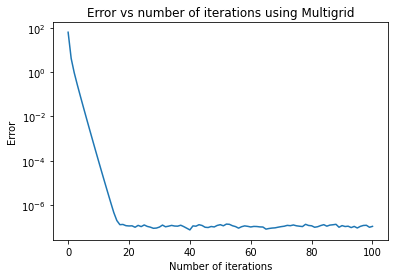

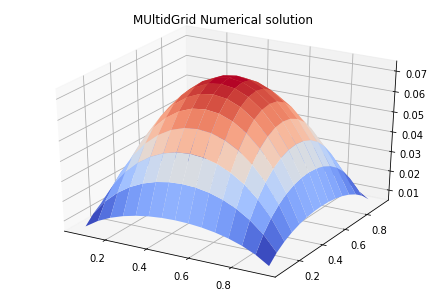

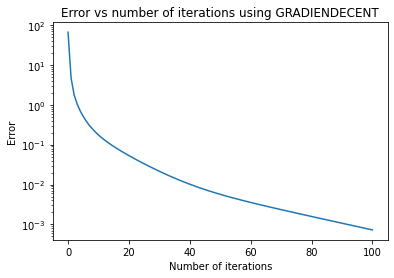

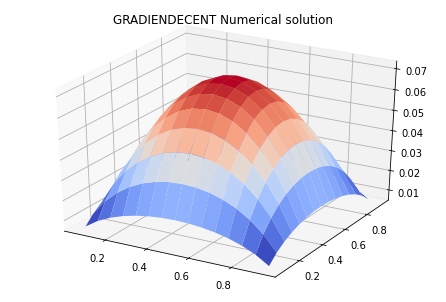

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import  torch.nn.functional as F
import torch.optim as optim
import torchvision
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

use_cuda = torch.cuda.is_available()
print('Use GPU?', use_cuda)


##### For MG: initlization of A, S, Pi, R, RT #####
def get_mg_init(A=None, S=None, Pi=None, R=None, RT=None):
    
    #Base on initial of matrix from book
    A_kernel = torch.tensor([[[[0,-1,0],[-1,4,-1],[0,-1,0]]]],dtype=torch.float32)
    S_kernel = torch.tensor([[[[0,1/64,0],[1/64,12/64,1/64],[0,1/64,0]]]],dtype=torch.float32)
    Pi_kernel = torch.tensor([[[[0,0,0],[0,0,0],[0,0,0]]]],dtype=torch.float32)
    R_kernel = torch.tensor([[[[0,0.5,0.5],[0.5,1,0.5],[0.5,0.5,0]]]],dtype=torch.float32)
    RT_kernel = torch.tensor([[[[0,0.5,0.5],[0.5,1,0.5],[0.5,0.5,0]]]],dtype=torch.float32)

    if A is not None:
        A.weight = torch.nn.Parameter(A_kernel)
    
    if S is not None:
        S.weight = torch.nn.Parameter(S_kernel)
        
    if Pi is not None:
        Pi.weight = torch.nn.Parameter(Pi_kernel)
    
    if R is not None:
        R.weight = torch.nn.Parameter(R_kernel)
    
    if RT is not None:
        RT.weight = torch.nn.Parameter(RT_kernel)
    
    return



##### For MG: setup for prolongation and error calculation #####
RT = nn.ConvTranspose2d(1, 1, kernel_size=3, stride=2, padding=0, bias=False)
get_mg_init(None,None,None,None,RT)
A = nn.Conv2d(1, 1, kernel_size=3,stride=1, padding=1, bias=False)
get_mg_init(A,None,None,None,None)



class MgIte(nn.Module):
    def __init__(self, A, S):
        super().__init__()
        
        get_mg_init(A=A,S=S)                       ##### For MG: inilization of A, S #####

        self.A = A
        self.S = S
    
    def forward(self, out):
        u, f = out #we get this define from MG output 
        u = u + (self.S(((f-self.A(u)))))                                   ##### For MG: u = u + S*(f-A*u) #####
        out = (u, f)
        return out


class MgRestriction(nn.Module):
    def __init__(self, A_old, A, Pi, R):
        super().__init__()

        get_mg_init(A=A,Pi=Pi,R=R)            ##### For MG: inilization of A, Pi, R #####

        self.A_old = A_old
        self.A = A
        self.Pi = Pi
        self.R = R

    def forward(self, out):
        u_old, f_old = out #this is from input data
        u = self.Pi(u_old)                              ##### For MG: u = Pi*u_old #####
        f = self.R(f_old-self.A_old(u_old)) + self.A(u) ##### For MG: f = R*(f_old-A_old*u_old) + A*u #####  
        out = (u,f)
        return out

#This is the multigrid model that we are having 
#In multigrid: num_channel_input = 1, num_channel_u = 1, num_channel_f = 1
class MG(nn.Module):
    def __init__(self, num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes):
        super().__init__()
        self.num_iteration = num_iteration
        self.num_channel_u = num_channel_u
        
        #Define A and S
        #Since A is applied to u, so input is data u, output is f because of the minus operation
        A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

        layers = []  #layer is empty list
        for l, num_iteration_l in enumerate(num_iteration): #l: l-th layer.   num_iteration_l: the number of iterations of l-th layer
            for i in range(num_iteration_l):
                layers.append(MgIte(A, S))  #It stands for the A, S componet in the function, call function MGIte

            setattr(self, 'layer'+str(l), nn.Sequential(*layers)) #nn.sequentioal, convert a list to format , this operation helo pytorch to understand
            # set attribute. This is equivalent to define, the function above used to be:
            # self.layer1 = nn.Sequential(*layers)
            # self.layer2 = nn.Sequential(*layers)
            # ...
            # self.layerJ = nn.Sequential(*layers)


            # l starts from 0, if len(num_iteration) = 4, l=0,1,2,3
            if l < len(num_iteration)-1: # if l is not lastlayer, we operate
                A_old = A
                
                #Define restritction code here
                A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3,stride=1, padding=1, bias=False)
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

                ##### For MG: padding=0 #####  
                Pi = nn.Conv2d(num_channel_u, num_channel_u, kernel_size=3,stride=2, padding=0, bias=False)
                R  = nn.Conv2d(num_channel_f, num_channel_f, kernel_size=3, stride=2, padding=0, bias=False)
                
                layers= [MgRestriction(A_old, A, Pi, R)] #new layer in function 2 fo MGl/  model restriction 
        


    def forward(self, u, f):
        #Due to the function from book, output is only u and f
        out = (u, f) 

        u_list.append(u)                                      ##### For MG: save u^j, j=1,2,...,J #####
        for l in range(len(self.num_iteration)):
            #We use set up layer this way:
            #out = self.layer1(out)
            #out = self.layer2(out)
            # ... 
            #now we can use the function below, we use that when we do not know how many layers we have
            out = getattr(self, 'layer'+str(l))(out) 

            u, f = out                                        ##### For MG: save u^j, j=1,2,...,J #####
            u_list.append(u)                                  ##### For MG: save u^j, j=1,2,...,J #####

        return u                                        

def plot_solution(J,u,label_name):
    N = 2 ** J -1
    h = 1/2**J
    X = np.arange(h, 1, h)
    Y = np.arange(h, 1, h)
    X, Y = np.meshgrid(X,Y)   # create a mesh
    a = torch.reshape(u, (N, N))
    fig1 = plt.figure()
    ax = Axes3D(fig1)         # plot a 3D surface, (X,Y,u(X,Y))
    ax.plot_surface(X, Y, np.array(a.data), rstride=1, cstride=1, cmap=plt.cm.coolwarm)
    ax.set_title(label_name)

    
def plot_error(M,error,label_name):
    #print(np.linalg.norm((f-self.A(u)).reshape(-1).detach().numpy()))
    plt.figure()
    plt.title('Error vs number of iterations using '+label_name)
    plot = plt.plot(error)
    plt.xlabel('Number of iterations')
    plt.yscale('log')
    plt.ylabel('Error')
    plt.show()

#This is MG method
# Model setup
num_channel_input = 1
num_channel_u = 1
num_channel_f = 1
num_classes = 1 

J = 4 
#There is 4 layer with 2 iteration in each layer
num_iteration = [2,2,2,2]  # multigrid. change this to [2,0,0,0] gives the gradient descent method
MG0=MG(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)


##### For MG: PDE setup u=sin(2*pi*x)*sin(2*pi*y) #####

N = 2 ** J -1
h = 1/2**J
u_exact = torch.ones(1,1,N,N)
f = torch.ones(1,1,N,N) / (N+1) **2


##### For MG: Multigrid iteration #####
M = 100
u = torch.randn(1,1,N,N)
error = [np.linalg.norm((A(u)-f).detach().numpy())]  # calculate the Frobenius Norm of (A*u-f)

for m in range(M):
    u_list = []                                      # Save u^0,u^1,u^2,u^3...,u^J
    u = MG0(u,f) #Here we use MG0
    for j in range(J-1,0,-1):  #determine if it is restriction
        u_list[j] += RT(u_list[j+1])  #since kernel of pi is zero, so update here is  u_list*R
    u = u_list[1]
    error.append(np.linalg.norm((A(u)-f).detach().numpy())) # calculate the Frobenius Norm of (A*u-f)


##### Lian added for MG: Plot results #####
plot_error(M,error,'Multigrid')
plot_solution(J,u,'MUltidGrid Numerical solution') 


##################################################### GD  ##############################################################################
#There is 4 layer with 2 iteration in each layer
num_iteration = [2,0,0,0] # gradient decent method 
MG0=MG(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)


##### For MG: PDE setup u=sin(2*pi*x)*sin(2*pi*y) #####

N = 2 ** J -1
h = 1/2**J
u_exact = torch.ones(1,1,N,N)
f = torch.ones(1,1,N,N) / (N+1) **2


##### For MG: Multigrid iteration #####
M = 100
u = torch.randn(1,1,N,N)
error = [np.linalg.norm((A(u)-f).detach().numpy())]  # calculate the Frobenius Norm of (A*u-f)

for m in range(M):
    u_list = []                                      # Save u^0,u^1,u^2,u^3...,u^J
    u = MG0(u,f) #Here we use MG0
    for j in range(J-1,0,-1):  #determine if it is restriction
        u_list[j] += RT(u_list[j+1])  #since kernel of pi is zero, so update here is  u_list*R
    u = u_list[1]
    error.append(np.linalg.norm((A(u)-f).detach().numpy())) # calculate the Frobenius Norm of (A*u-f)

##### Lian added for MG: Plot results #####
plot_error(M,error,'GRADIENDECENT')
plot_solution(J,u,'GRADIENDECENT Numerical solution')   
    


=================================================================================================================

## Problem 2 [50%]: 

Use SGD with momentum and weight decay to train MgNet on the Cifar10 dataset. Use 120 epochs, set the initial learning rate to 0.1, momentum to 0.9, weight decay to 0.0005, and divide the learning rate by 10 every 30 epochs. (The code to do this has been provided.) Let $b_i$ denote the test accuracy of the model after $i$ epochs, and let $b^*$ = $\max_i(b_i)$ be the best test accuracy attained during training.


### Tasks:
   * [30%] Train MgNet with the following three sets of hyper-parameters (As a reminder, the hyper-parameters of MgNet are $\nu$, the number of iterations of each layer, $c_u$, the number of channels for $u$, and $c_f$, the number of channels for $f$.):
 
    (1) $\nu=$[1,1,1,1], $c_u=c_f=64$.
    
    (2) $\nu=$[2,2,2,2], $c_u=c_f=64$.

    (3) $\nu=$[2,2,2,2], $c_u=c_f=64$, try to improve the test accuracy by implementing MgNet with $S^{l,i}$, which means different iterations in the same layer do not share the same $S^{l}$. 
  
  
   * For each numerical experiment above, print the results with the following format:

       "Epoch: i, Learning rate: lr$_i$, Training accuracy: $a_i$, Test accuracy: $b_i$"

        where $i=1,2,3,...$ means the $i$-th epoch,  $a_i$ and $b_i$ are the training accuracy and test accuracy computed at the end of $i$-th epoch, and lr$_i$ is the learning rate of $i$-th epoch.
    
    
   * [10%] For each numerical experiment above, plot the test accuracy against the epoch count, i.e. the x-axis is the number of epochs $i$ and y-axis is the test accuracy $b_i$. An example plot is shown in the next cell.
   
   
   * [10%] Calculate the number of parameters that each of the above models has. Discuss why the number of parameters is different (or the same) for each of the models.
       

Use GPU? True
Files already downloaded and verified
Files already downloaded and verified
Computation Time for training: 65.21467413699975
Computation Time for training accuracy: 19.16102059200057
Computation Time for test accuracy: 3.3132299879998754
Epoch: 1, learning rate: 0.1, the training accuracy: 0.40586, the test accuracy: 0.3867
Computation Time for one epoch: 87.69315848500082
Computation Time for training: 65.01063025099938
Computation Time for training accuracy: 19.113512960000662
Computation Time for test accuracy: 3.2935003580005286
Epoch: 2, learning rate: 0.1, the training accuracy: 0.62472, the test accuracy: 0.6159
Computation Time for one epoch: 87.41965325599995
Computation Time for training: 64.94717651199971
Computation Time for training accuracy: 19.15070487599951
Computation Time for test accuracy: 3.2630291519999446
Epoch: 3, learning rate: 0.1, the training accuracy: 0.67704, the test accuracy: 0.6701
Computation Time for one epoch: 87.36247533099959
Computati

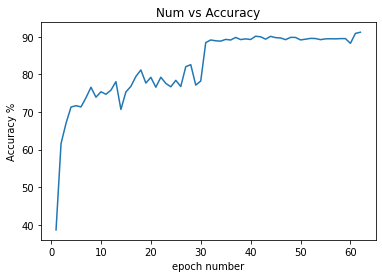

Total Computation Time: 5375.575171725999


In [ ]:
import torch
import numpy as np
import torch.nn as nn
import  torch.nn.functional as F
import torch.optim as optim
import torchvision
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

use_cuda = torch.cuda.is_available()
print('Use GPU?', use_cuda)



class MgIte(nn.Module):
    def __init__(self, A, S):
        super().__init__()
        
        self.A = A
        self.S = S

        self.bn1 =nn.BatchNorm2d(A.weight.size(0)) ##### For MgNet: BN #####
        self.bn2 =nn.BatchNorm2d(S.weight.size(0)) ##### For MgNet: BN #####
    
    def forward(self, out):
        u, f = out #we get this define from MG output 
        u = u + F.relu(self.bn2(self.S(F.relu(self.bn1((f-self.A(u)))))))   ##### For MgNet: add BN and ReLU #####
        out = (u, f)
        return out



class MgRestriction(nn.Module):
    def __init__(self, A_old, A, Pi, R):
        super().__init__()

        self.A_old = A_old
        self.A = A
        self.Pi = Pi
        self.R = R

        self.bn1 = nn.BatchNorm2d(Pi.weight.size(0))   ##### For MgNet: BN #####
        self.bn2 = nn.BatchNorm2d(R.weight.size(0))    ##### For MgNet: BN #####

    def forward(self, out):
        u_old, f_old = out #this is from input data
        u = F.relu(self.bn1(self.Pi(u_old)))                              ##### For MgNet: add BN and ReLU #####
        f = F.relu(self.bn2(self.R(f_old-self.A_old(u_old)))) + self.A(u) ##### For MgNet: add BN and ReLU #####        
        out = (u,f)
        return out

#This is the multigrid model that we are having 
#In multigrid: num_channel_input = 1, num_channel_u = 1, num_channel_f = 1
class MgNet(nn.Module):
    def __init__(self, num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes):
        super().__init__()
        self.num_iteration = num_iteration
        self.num_channel_u = num_channel_u
        
        ##### For MgNet: Initialization layer #####
        self.conv1 = nn.Conv2d(num_channel_input, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channel_f)        

        #Define A and S
        #Since A is applied to u, so input is data u, output is f because of the minus operation
        A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

        layers = []  #layer is empty list
        for l, num_iteration_l in enumerate(num_iteration): #l: l-th layer.   num_iteration_l: the number of iterations of l-th layer
            for i in range(num_iteration_l):
                layers.append(MgIte(A, S))  #It stands for the A, S componet in the function, call function MGIte

            setattr(self, 'layer'+str(l), nn.Sequential(*layers)) #nn.sequentioal, convert a list to format , this operation helo pytorch to understand
            # set attribute. This is equivalent to define, the function above used to be:
            # self.layer1 = nn.Sequential(*layers)
            # self.layer2 = nn.Sequential(*layers)
            # ...
            # self.layerJ = nn.Sequential(*layers)


            # l starts from 0, if len(num_iteration) = 4, l=0,1,2,3
            if l < len(num_iteration)-1: # if l is not lastlayer, we operate
                A_old = A
                
                #Define restritction code here
                A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3,stride=1, padding=1, bias=False)
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

                ##### For MgNet: padding=1 #####
                Pi = nn.Conv2d(num_channel_u, num_channel_u, kernel_size=3,stride=2, padding=1, bias=False)
                R = nn.Conv2d(num_channel_f, num_channel_f, kernel_size=3, stride=2, padding=1, bias=False)
                
                
                
                layers= [MgRestriction(A_old, A, Pi, R)] #new layer in function 2 fo MGl/  model restriction 
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        self.pooling = nn.AdaptiveAvgPool2d(1)  # pooling the data in each channel to size=1
        self.fc = nn.Linear(num_channel_u ,num_classes)

    def forward(self, u, f):
        #size of f[batch size, channels, size, size]
        f = F.relu(self.bn1(self.conv1(f)))                 ##### For MgNet: initialization of f #####
        if use_cuda:                                        ##### For MgNet: initialization of u #####
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3), device=torch.device('cuda'))
        else:
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3))        

        out = (u,f)
        for l in range(len(self.num_iteration)):
            #We use set up layer this way:
            #out = self.layer1(out)
            #out = self.layer2(out)
            # ... 
            #now we can use the function below, we use that when we do not know how many layers we have
            out = getattr(self, 'layer'+str(l))(out) 

        ##### For MgNet: average pooling and fully connected layer for classification #####
        u, f = out       
        u = self.pooling(u)
        u = u.view(u.shape[0], -1)
        u = self.fc(u)
        return u                                        

def adjust_learning_rate(optimizer, epoch, init_lr):
    #lr = 1.0 / (epoch + 1)
    lr = init_lr * 0.1 ** (epoch // 30)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

minibatch_size = 128
num_epochs = 120
lr = 0.1

num_channel_input = 3
num_channel_u = 64  #128,256,512
num_channel_f = 64
num_classes = 10 
num_iteration = [1,1,1,1] #2,2,2,2  or 2,1,1,1

# Step 1: Define a model
my_model = MgNet(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)

if use_cuda:
    my_model = my_model.cuda()

# Step 2: Define a loss function and training algorithm
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model.parameters(), lr=lr, momentum=0.9, weight_decay = 0.0005)


# Step 3: load dataset
normalize = torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))

transform_train = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32, padding=4),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor(),
                                                  normalize])

transform_test  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),normalize])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatch_size, shuffle=False)


start = timer()

#set array for number in order to plot
epoch_list=[]
Accuracy_list=[]

#Step 4: Train the NNs
# One epoch is when an entire dataset is passed through the neural network only once.

for epoch in range(num_epochs):
    start_epoch = timer()

    current_lr = adjust_learning_rate(optimizer, epoch, lr)

    start_training = timer()
    my_model.train()
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()

        # Forward pass to get the loss
        outputs = my_model(0,images)   # We need additional 0 input for u in MgNet
        loss = criterion(outputs, labels)
        
        # Backward and compute the gradient
        optimizer.zero_grad()
        loss.backward()  #backpropragation
        optimizer.step() #update the weights/parameters
    end_training = timer()
    print('Computation Time for training:',end_training - start_training)

  # Training accuracy
    start_training_acc = timer()
    my_model.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()  
          outputs = my_model(0,images)  # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    training_accuracy = float(correct)/total
    end_training_acc = timer()
    print('Computation Time for training accuracy:',end_training_acc - start_training_acc)

    
    # Test accuracy
    start_test_acc = timer()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()
          outputs = my_model(0,images)      # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    test_accuracy = float(correct)/total
    end_test_acc = timer()
    print('Computation Time for test accuracy:',end_test_acc - start_test_acc)
    
    epoch_list.append(epoch+1)
    Accuracy_list.append(test_accuracy*100)

    print('Epoch: {}, learning rate: {}, the training accuracy: {}, the test accuracy: {}' .format(epoch+1,current_lr,training_accuracy,test_accuracy)) 
    end_epoch = timer()
    print('Computation Time for one epoch:',end_epoch - start_epoch)
    if(test_accuracy >= 0.91):
      break


def plot_result(epoch_list,Accuracy_list):
    plt.figure()
    plt.title('Num vs Accuracy')
    plot = plt.plot(epoch_list,Accuracy_list)
    plt.xlabel('epoch number')
    plt.ylabel('Accuracy %')
    plt.show()

model_size = sum(param.numel() for param in my_model.parameters())
print('the model size is:',model_size)
plot_result(epoch_list,Accuracy_list)


end = timer()
print('Total Computation Time:',end - start)

In [ ]:
num_iteration = [2,2,2,2] #2,2,2,2  or 2,1,1,1

# Step 1: Define a model
my_model = MgNet(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)

if use_cuda:
    my_model = my_model.cuda()

# Step 2: Define a loss function and training algorithm
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model.parameters(), lr=lr, momentum=0.9, weight_decay = 0.0005)


# Step 3: load dataset
normalize = torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))

transform_train = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32, padding=4),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor(),
                                                  normalize])

transform_test  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),normalize])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatch_size, shuffle=False)


start = timer()

#set array for number in order to plot
epoch_list=[]
Accuracy_list=[]

#Step 4: Train the NNs
# One epoch is when an entire dataset is passed through the neural network only once.

for epoch in range(num_epochs):
    start_epoch = timer()

    current_lr = adjust_learning_rate(optimizer, epoch, lr)

    start_training = timer()
    my_model.train()
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()

        # Forward pass to get the loss
        outputs = my_model(0,images)   # We need additional 0 input for u in MgNet
        loss = criterion(outputs, labels)
        
        # Backward and compute the gradient
        optimizer.zero_grad()
        loss.backward()  #backpropragation
        optimizer.step() #update the weights/parameters
    end_training = timer()
    print('Computation Time for training:',end_training - start_training)

  # Training accuracy
    start_training_acc = timer()
    my_model.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()  
          outputs = my_model(0,images)  # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    training_accuracy = float(correct)/total
    end_training_acc = timer()
    print('Computation Time for training accuracy:',end_training_acc - start_training_acc)

    
    # Test accuracy
    start_test_acc = timer()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()
          outputs = my_model(0,images)      # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    test_accuracy = float(correct)/total
    end_test_acc = timer()
    print('Computation Time for test accuracy:',end_test_acc - start_test_acc)
    
    epoch_list.append(epoch+1)
    Accuracy_list.append(test_accuracy*100)

    print('Epoch: {}, learning rate: {}, the training accuracy: {}, the test accuracy: {}' .format(epoch+1,current_lr,training_accuracy,test_accuracy)) 
    end_epoch = timer()
    print('Computation Time for one epoch:',end_epoch - start_epoch)

end = timer()
print('Total Computation Time:',end - start)

Files already downloaded and verified
Files already downloaded and verified
Computation Time for training: 158.42641659499895
Computation Time for training accuracy: 41.81106542799898
Computation Time for test accuracy: 8.338586964999195
Epoch: 1, learning rate: 0.1, the training accuracy: 0.4699, the test accuracy: 0.4707
Computation Time for one epoch: 208.57790102299987
Computation Time for training: 158.24703474000125
Computation Time for training accuracy: 41.785932386999775
Computation Time for test accuracy: 8.339744258000792
Epoch: 2, learning rate: 0.1, the training accuracy: 0.5746, the test accuracy: 0.5877
Computation Time for one epoch: 208.3735225370001
Computation Time for training: 158.2883721220005
Computation Time for training accuracy: 41.786373416998686
Computation Time for test accuracy: 8.352400284999021
Epoch: 3, learning rate: 0.1, the training accuracy: 0.62318, the test accuracy: 0.6209
Computation Time for one epoch: 208.42810037600066
Computation Time for tr

KeyboardInterrupt: ignored

the model size is: 2075018


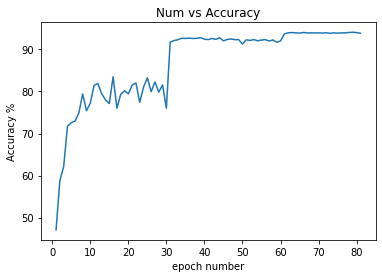

In [ ]:
def plot_result(epoch_list,Accuracy_list):
    plt.figure()
    plt.title('Num vs Accuracy')
    plot = plt.plot(epoch_list,Accuracy_list)
    plt.xlabel('epoch number')
    plt.ylabel('Accuracy %')
    plt.show()

model_size = sum(param.numel() for param in my_model.parameters())
print('the model size is:',model_size)
plot_result(epoch_list,Accuracy_list)

=================================================================================================================

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import  torch.nn.functional as F
import torch.optim as optim
import torchvision
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

use_cuda = torch.cuda.is_available()
print('Use GPU?', use_cuda)

class MgIte(nn.Module):
    def __init__(self, A, S):
        super().__init__()
        
        self.A = A
        self.S = S

        self.bn1 =nn.BatchNorm2d(A.weight.size(0)) ##### For MgNet: BN #####
        self.bn2 =nn.BatchNorm2d(S.weight.size(0)) ##### For MgNet: BN #####
    
    def forward(self, out):
        u, f = out #we get this define from MG output 
        u = u + F.relu(self.bn2(self.S(F.relu(self.bn1((f-self.A(u)))))))   ##### For MgNet: add BN and ReLU #####
        out = (u, f)
        return out



class MgRestriction(nn.Module):
    def __init__(self, A_old, A, Pi, R):
        super().__init__()

        self.A_old = A_old
        self.A = A
        self.Pi = Pi
        self.R = R

        self.bn1 = nn.BatchNorm2d(Pi.weight.size(0))   ##### For MgNet: BN #####
        self.bn2 = nn.BatchNorm2d(R.weight.size(0))    ##### For MgNet: BN #####

    def forward(self, out):
        u_old, f_old = out #this is from input data
        u = F.relu(self.bn1(self.Pi(u_old)))                              ##### For MgNet: add BN and ReLU #####
        f = F.relu(self.bn2(self.R(f_old-self.A_old(u_old)))) + self.A(u) ##### For MgNet: add BN and ReLU #####        
        out = (u,f)
        return out

#This is the multigrid model that we are having 
#In multigrid: num_channel_input = 1, num_channel_u = 1, num_channel_f = 1
class MgNet(nn.Module):
    def __init__(self, num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes):
        super().__init__()
        self.num_iteration = num_iteration
        self.num_channel_u = num_channel_u
        
        ##### For MgNet: Initialization layer #####
        self.conv1 = nn.Conv2d(num_channel_input, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channel_f)        

        #Define A and S
        #Since A is applied to u, so input is data u, output is f because of the minus operation
        A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)

        layers = []  #layer is empty list
        for l, num_iteration_l in enumerate(num_iteration): #l: l-th layer.   num_iteration_l: the number of iterations of l-th layer
            for i in range(num_iteration_l):
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)
                layers.append(MgIte(A, S))  #It stands for the A, S componet in the function, call function MGIte

            setattr(self, 'layer'+str(l), nn.Sequential(*layers)) #nn.sequentioal, convert a list to format , this operation helo pytorch to understand


            # l starts from 0, if len(num_iteration) = 4, l=0,1,2,3
            if l < len(num_iteration)-1: # if l is not lastlayer, we operate
                A_old = A
                
                #Define restritction code here
                A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3,stride=1, padding=1, bias=False)
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

                ##### For MgNet: padding=1 #####
                Pi = nn.Conv2d(num_channel_u, num_channel_u, kernel_size=3,stride=2, padding=1, bias=False)
                R = nn.Conv2d(num_channel_f, num_channel_f, kernel_size=3, stride=2, padding=1, bias=False)
                
                
                
                layers= [MgRestriction(A_old, A, Pi, R)] #new layer in function 2 fo MGl/  model restriction 
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        self.pooling = nn.AdaptiveAvgPool2d(1)  # pooling the data in each channel to size=1
        self.fc = nn.Linear(num_channel_u ,num_classes)

    def forward(self, u, f):
        #size of f[batch size, channels, size, size]
        f = F.relu(self.bn1(self.conv1(f)))                 ##### For MgNet: initialization of f #####
        if use_cuda:                                        ##### For MgNet: initialization of u #####
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3), device=torch.device('cuda'))
        else:
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3))        

        out = (u,f)
        for l in range(len(self.num_iteration)):
            #We use set up layer this way:
            #out = self.layer1(out)
            #out = self.layer2(out)
            # ... 
            #now we can use the function below, we use that when we do not know how many layers we have
            out = getattr(self, 'layer'+str(l))(out) 

        ##### For MgNet: average pooling and fully connected layer for classification #####
        u, f = out       
        u = self.pooling(u)
        u = u.view(u.shape[0], -1)
        u = self.fc(u)
        return u                                        

def adjust_learning_rate(optimizer, epoch, init_lr):
    #lr = 1.0 / (epoch + 1)
    lr = init_lr * 0.1 ** (epoch // 30)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

minibatch_size = 128
num_epochs = 120
lr = 0.1

num_channel_input = 3
num_channel_u = 64  #128,256,512
num_channel_f = 64
num_classes = 10 
num_iteration = [2,2,2,2] #2,2,2,2  or 2,1,1,1

# Step 1: Define a model
my_model = MgNet(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)

if use_cuda:
    my_model = my_model.cuda()

# Step 2: Define a loss function and training algorithm
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model.parameters(), lr=lr, momentum=0.9, weight_decay = 0.0005)


# Step 3: load dataset
normalize = torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))

transform_train = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32, padding=4),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor(),
                                                  normalize])

transform_test  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),normalize])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatch_size, shuffle=False)


start = timer()

#set array for number in order to plot
epoch_list=[]
Accuracy_list=[]

#Step 4: Train the NNs
# One epoch is when an entire dataset is passed through the neural network only once.

for epoch in range(num_epochs):
    start_epoch = timer()

    current_lr = adjust_learning_rate(optimizer, epoch, lr)

    start_training = timer()
    my_model.train()
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()

        # Forward pass to get the loss
        outputs = my_model(0,images)   # We need additional 0 input for u in MgNet
        loss = criterion(outputs, labels)
        
        # Backward and compute the gradient
        optimizer.zero_grad()
        loss.backward()  #backpropragation
        optimizer.step() #update the weights/parameters
    end_training = timer()
    print('Computation Time for training:',end_training - start_training)

  # Training accuracy
    start_training_acc = timer()
    my_model.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()  
          outputs = my_model(0,images)  # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    training_accuracy = float(correct)/total
    end_training_acc = timer()
    print('Computation Time for training accuracy:',end_training_acc - start_training_acc)

    
    # Test accuracy
    start_test_acc = timer()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()
          outputs = my_model(0,images)      # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    test_accuracy = float(correct)/total
    end_test_acc = timer()
    print('Computation Time for test accuracy:',end_test_acc - start_test_acc)
    
    epoch_list.append(epoch+1)
    Accuracy_list.append(test_accuracy*100)

    print('Epoch: {}, learning rate: {}, the training accuracy: {}, the test accuracy: {}' .format(epoch+1,current_lr,training_accuracy,test_accuracy)) 
    end_epoch = timer()
    print('Computation Time for one epoch:',end_epoch - start_epoch) 


Use GPU? True


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Computation Time for training: 98.39435273200002
Computation Time for training accuracy: 22.22916902899999
Computation Time for test accuracy: 4.412835803999997
Epoch: 1, learning rate: 0.1, the training accuracy: 0.47604, the test accuracy: 0.4908
Computation Time for one epoch: 125.03836956500004
Computation Time for training: 98.14065069000003
Computation Time for training accuracy: 22.23390753000001
Computation Time for test accuracy: 4.406233868999948
Epoch: 2, learning rate: 0.1, the training accuracy: 0.6182, the test accuracy: 0.6115
Computation Time for one epoch: 124.78191859000003
Computation Time for training: 98.13995370100008
Computation Time for training accuracy: 22.07741816700002
Computation Time for test accuracy: 4.408813823999935
Epoch: 3, learning rate: 0.1, the training accuracy: 0.67118, the test accuracy: 0.6746
Computation Time for one epoch: 124.62731702500002
Computation 

KeyboardInterrupt: ignored

the model size is: 668874


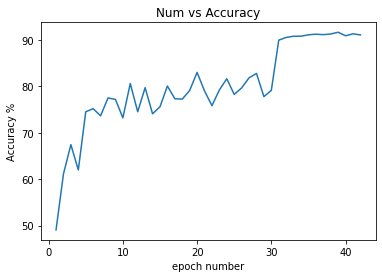

Total Computation Time: 5360.953090591


In [ ]:
def plot_result(epoch_list,Accuracy_list):
    plt.figure()
    plt.title('Num vs Accuracy')
    plot = plt.plot(epoch_list,Accuracy_list)
    plt.xlabel('epoch number')
    plt.ylabel('Accuracy %')
    plt.show()

model_size = sum(param.numel() for param in my_model.parameters())
print('the model size is:',model_size)
plot_result(epoch_list,Accuracy_list)


end = timer()
print('Total Computation Time:',end - start)

## Problem 3:

Fix the number of channels $c_u=c_f=128$, try different $\nu$ to achieve test accuracy as high as possible.

### Requirement:
   * Report $b^{*}$, $\nu$ and the number of parameters of your model.
   * Plot a curve, where the x-axis is the number of epoch $i$ and y-axis is the test accuracy $b_i$.

Use GPU? True
Files already downloaded and verified
Files already downloaded and verified
Computation Time for training: 158.36805762799997
Computation Time for training accuracy: 41.79004104399996
Computation Time for test accuracy: 8.346117663000086
Epoch: 1, learning rate: 0.1, the training accuracy: 0.44218, the test accuracy: 0.4453
current maximum test accuracy: 0.4453
Computation Time for one epoch: 208.50583715400012
Computation Time for training: 158.09942512099997
Computation Time for training accuracy: 41.78748944600011
Computation Time for test accuracy: 8.357453074999967
Epoch: 2, learning rate: 0.1, the training accuracy: 0.49658, the test accuracy: 0.5026
current maximum test accuracy: 0.5026
Computation Time for one epoch: 208.24565543100016
Computation Time for training: 158.15195190699978
Computation Time for training accuracy: 41.79659708700001
Computation Time for test accuracy: 8.366989271999955
Epoch: 3, learning rate: 0.1, the training accuracy: 0.69794, the test

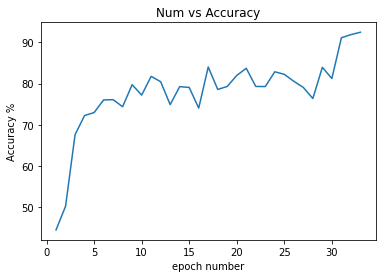

Total Computation Time: 6847.794156294


In [ ]:
import torch
import numpy as np
import torch.nn as nn
import  torch.nn.functional as F
import torch.optim as optim
import torchvision
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

use_cuda = torch.cuda.is_available()
print('Use GPU?', use_cuda)



class MgIte(nn.Module):
    def __init__(self, A, S):
        super().__init__()
        
        self.A = A
        self.S = S

        self.bn1 =nn.BatchNorm2d(A.weight.size(0)) ##### For MgNet: BN #####
        self.bn2 =nn.BatchNorm2d(S.weight.size(0)) ##### For MgNet: BN #####
    
    def forward(self, out):
        u, f = out #we get this define from MG output 
        u = u + F.relu(self.bn2(self.S(F.relu(self.bn1((f-self.A(u)))))))   ##### For MgNet: add BN and ReLU #####
        out = (u, f)
        return out



class MgRestriction(nn.Module):
    def __init__(self, A_old, A, Pi, R):
        super().__init__()

        self.A_old = A_old
        self.A = A
        self.Pi = Pi
        self.R = R

        self.bn1 = nn.BatchNorm2d(Pi.weight.size(0))   ##### For MgNet: BN #####
        self.bn2 = nn.BatchNorm2d(R.weight.size(0))    ##### For MgNet: BN #####

    def forward(self, out):
        u_old, f_old = out #this is from input data
        u = F.relu(self.bn1(self.Pi(u_old)))                              ##### For MgNet: add BN and ReLU #####
        f = F.relu(self.bn2(self.R(f_old-self.A_old(u_old)))) + self.A(u) ##### For MgNet: add BN and ReLU #####        
        out = (u,f)
        return out

#This is the multigrid model that we are having 
#In multigrid: num_channel_input = 1, num_channel_u = 1, num_channel_f = 1
class MgNet(nn.Module):
    def __init__(self, num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes):
        super().__init__()
        self.num_iteration = num_iteration
        self.num_channel_u = num_channel_u
        
        ##### For MgNet: Initialization layer #####
        self.conv1 = nn.Conv2d(num_channel_input, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channel_f)        

        #Define A and S
        #Since A is applied to u, so input is data u, output is f because of the minus operation
        A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

        layers = []  #layer is empty list
        for l, num_iteration_l in enumerate(num_iteration): #l: l-th layer.   num_iteration_l: the number of iterations of l-th layer
            for i in range(num_iteration_l):
                layers.append(MgIte(A, S))  #It stands for the A, S componet in the function, call function MGIte

            setattr(self, 'layer'+str(l), nn.Sequential(*layers)) #nn.sequentioal, convert a list to format , this operation helo pytorch to understand
            # set attribute. This is equivalent to define, the function above used to be:
            # self.layer1 = nn.Sequential(*layers)
            # self.layer2 = nn.Sequential(*layers)
            # ...
            # self.layerJ = nn.Sequential(*layers)


            # l starts from 0, if len(num_iteration) = 4, l=0,1,2,3
            if l < len(num_iteration)-1: # if l is not lastlayer, we operate
                A_old = A
                
                #Define restritction code here
                A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3,stride=1, padding=1, bias=False)
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

                ##### For MgNet: padding=1 #####
                Pi = nn.Conv2d(num_channel_u, num_channel_u, kernel_size=3,stride=2, padding=1, bias=False)
                R = nn.Conv2d(num_channel_f, num_channel_f, kernel_size=3, stride=2, padding=1, bias=False)
                
                
                layers= [MgRestriction(A_old, A, Pi, R)] #new layer in function 2 fo MGl/  model restriction 
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        self.pooling = nn.AdaptiveAvgPool2d(1)  # pooling the data in each channel to size=1
        self.fc = nn.Linear(num_channel_u ,num_classes)

    def forward(self, u, f):
        #size of f[batch size, channels, size, size]
        f = F.relu(self.bn1(self.conv1(f)))                 ##### For MgNet: initialization of f #####
        if use_cuda:                                        ##### For MgNet: initialization of u #####
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3), device=torch.device('cuda'))
        else:
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3))        

        out = (u,f)
        for l in range(len(self.num_iteration)):
            #We use set up layer this way:
            #out = self.layer1(out)
            #out = self.layer2(out)
            # ... 
            #now we can use the function below, we use that when we do not know how many layers we have
            out = getattr(self, 'layer'+str(l))(out) 

        ##### For MgNet: average pooling and fully connected layer for classification #####
        u, f = out       
        u = self.pooling(u)
        u = u.view(u.shape[0], -1)
        u = self.fc(u)
        return u                                        

def adjust_learning_rate(optimizer, epoch, init_lr):
    #lr = 1.0 / (epoch + 1)
    lr = init_lr * 0.1 ** (epoch // 30)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

minibatch_size = 128
num_epochs = 120
lr = 0.1

num_channel_input = 3
num_channel_u = 128  #128,256,512
num_channel_f = 128
num_classes = 10 
num_iteration = [2,2,2,2] #2,2,2,2  or 2,1,1,1

# Step 1: Define a model
my_model = MgNet(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)

if use_cuda:
    my_model = my_model.cuda()

# Step 2: Define a loss function and training algorithm
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model.parameters(), lr=lr, momentum=0.9, weight_decay = 0.0005)


# Step 3: load dataset
normalize = torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))

transform_train = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32, padding=4),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor(),
                                                  normalize])

transform_test  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),normalize])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatch_size, shuffle=False)


start = timer()

#set array for number in order to plot
epoch_list=[]
Accuracy_list=[]
b_max=0
temp=0

#Step 4: Train the NNs
# One epoch is when an entire dataset is passed through the neural network only once.

for epoch in range(num_epochs):
    start_epoch = timer()

    current_lr = adjust_learning_rate(optimizer, epoch, lr)

    start_training = timer()
    my_model.train()
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()

        # Forward pass to get the loss
        outputs = my_model(0,images)   # We need additional 0 input for u in MgNet
        loss = criterion(outputs, labels)
        
        # Backward and compute the gradient
        optimizer.zero_grad()
        loss.backward()  #backpropragation
        optimizer.step() #update the weights/parameters
    end_training = timer()
    print('Computation Time for training:',end_training - start_training)

  # Training accuracy
    start_training_acc = timer()
    my_model.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()  
          outputs = my_model(0,images)  # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    training_accuracy = float(correct)/total
    end_training_acc = timer()
    print('Computation Time for training accuracy:',end_training_acc - start_training_acc)

    
    # Test accuracy
    start_test_acc = timer()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()
          outputs = my_model(0,images)      # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    test_accuracy = float(correct)/total
    end_test_acc = timer()
    print('Computation Time for test accuracy:',end_test_acc - start_test_acc)
    
    epoch_list.append(epoch+1)
    Accuracy_list.append(test_accuracy*100)

    
    temp = test_accuracy
    if temp > b_max:
      b_max = temp
    print('Epoch: {}, learning rate: {}, the training accuracy: {}, the test accuracy: {}' .format(epoch+1,current_lr,training_accuracy,test_accuracy))
    end_epoch = timer()
    print("current maximum test accuracy:",b_max)
    print('Computation Time for one epoch:',end_epoch - start_epoch)
    if(test_accuracy >= 0.92):
      break




def plot_result(epoch_list,Accuracy_list):
    plt.figure()
    plt.title('Num vs Accuracy')
    plot = plt.plot(epoch_list,Accuracy_list)
    plt.xlabel('epoch number')
    plt.ylabel('Accuracy %')
    plt.show()

model_size = sum(param.numel() for param in my_model.parameters())
print('b*(max b):{},v:{},the number of parameters of model:{}'.format(b_max,num_iteration,model_size))
plot_result(epoch_list,Accuracy_list)

end = timer()
print('Total Computation Time:',end - start)


Since we change V and get 92 in 30 epoch, changing v actually give us a better accuracy, I get 93% in 108 epoch before. But because the colab does not support the long run, it stop at 108 during night, so I only have result for 108, but still, it's pretty clear that it get better accuracy (detail about that process is attached with this final project file


=================================================================================================================

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import  torch.nn.functional as F
import torch.optim as optim
import torchvision
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

use_cuda = torch.cuda.is_available()
print('Use GPU?', use_cuda)



class MgIte(nn.Module):
    def __init__(self, A, S):
        super().__init__()
        
        self.A = A
        self.S = S

        self.bn1 =nn.BatchNorm2d(A.weight.size(0)) ##### For MgNet: BN #####
        self.bn2 =nn.BatchNorm2d(S.weight.size(0)) ##### For MgNet: BN #####
    
    def forward(self, out):
        u, f = out #we get this define from MG output 
        u = u + F.relu(self.bn2(self.S(F.relu(self.bn1((f-self.A(u)))))))   ##### For MgNet: add BN and ReLU #####
        out = (u, f)
        return out



class MgRestriction(nn.Module):
    def __init__(self, A_old, A, Pi, R):
        super().__init__()

        self.A_old = A_old
        self.A = A
        self.Pi = Pi
        self.R = R

        self.bn1 = nn.BatchNorm2d(Pi.weight.size(0))   ##### For MgNet: BN #####
        self.bn2 = nn.BatchNorm2d(R.weight.size(0))    ##### For MgNet: BN #####

    def forward(self, out):
        u_old, f_old = out #this is from input data
        u = F.relu(self.bn1(self.Pi(u_old)))                              ##### For MgNet: add BN and ReLU #####
        f = F.relu(self.bn2(self.R(f_old-self.A_old(u_old)))) + self.A(u) ##### For MgNet: add BN and ReLU #####        
        out = (u,f)
        return out

#This is the multigrid model that we are having 
#In multigrid: num_channel_input = 1, num_channel_u = 1, num_channel_f = 1
class MgNet(nn.Module):
    def __init__(self, num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes):
        super().__init__()
        self.num_iteration = num_iteration
        self.num_channel_u = num_channel_u
        
        ##### For MgNet: Initialization layer #####
        self.conv1 = nn.Conv2d(num_channel_input, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channel_f)        

        #Define A and S
        #Since A is applied to u, so input is data u, output is f because of the minus operation
        A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

        layers = []  #layer is empty list
        for l, num_iteration_l in enumerate(num_iteration): #l: l-th layer.   num_iteration_l: the number of iterations of l-th layer
            for i in range(num_iteration_l):
                layers.append(MgIte(A, S))  #It stands for the A, S componet in the function, call function MGIte

            setattr(self, 'layer'+str(l), nn.Sequential(*layers)) #nn.sequentioal, convert a list to format , this operation helo pytorch to understand
            # set attribute. This is equivalent to define, the function above used to be:
            # self.layer1 = nn.Sequential(*layers)
            # self.layer2 = nn.Sequential(*layers)
            # ...
            # self.layerJ = nn.Sequential(*layers)


            # l starts from 0, if len(num_iteration) = 4, l=0,1,2,3
            if l < len(num_iteration)-1: # if l is not lastlayer, we operate
                A_old = A
                
                #Define restritction code here
                A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3,stride=1, padding=1, bias=False)
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

                ##### For MgNet: padding=1 #####
                Pi = nn.Conv2d(num_channel_u, num_channel_u, kernel_size=3,stride=2, padding=1, bias=False)
                R = nn.Conv2d(num_channel_f, num_channel_f, kernel_size=3, stride=2, padding=1, bias=False)
                
                
                layers= [MgRestriction(A_old, A, Pi, R)] #new layer in function 2 fo MGl/  model restriction 
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        self.pooling = nn.AdaptiveAvgPool2d(1)  # pooling the data in each channel to size=1
        self.fc = nn.Linear(num_channel_u ,num_classes)

    def forward(self, u, f):
        #size of f[batch size, channels, size, size]
        f = F.relu(self.bn1(self.conv1(f)))                 ##### For MgNet: initialization of f #####
        if use_cuda:                                        ##### For MgNet: initialization of u #####
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3), device=torch.device('cuda'))
        else:
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3))        

        out = (u,f)
        for l in range(len(self.num_iteration)):
            #We use set up layer this way:
            #out = self.layer1(out)
            #out = self.layer2(out)
            # ... 
            #now we can use the function below, we use that when we do not know how many layers we have
            out = getattr(self, 'layer'+str(l))(out) 

        ##### For MgNet: average pooling and fully connected layer for classification #####
        u, f = out       
        u = self.pooling(u)
        u = u.view(u.shape[0], -1)
        u = self.fc(u)
        return u                                        

def adjust_learning_rate(optimizer, epoch, init_lr):
    #lr = 1.0 / (epoch + 1)
    lr = init_lr * 0.1 ** (epoch // 30)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

minibatch_size = 128
num_epochs = 30
lr = 0.1

num_channel_input = 3
num_channel_u = 128  #128,256,512
num_channel_f = 128
num_classes = 10 
num_iteration = [2,1,1,1] #2,2,2,2  or 2,1,1,1

# Step 1: Define a model
my_model = MgNet(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)

if use_cuda:
    my_model = my_model.cuda()

# Step 2: Define a loss function and training algorithm
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model.parameters(), lr=lr, momentum=0.9, weight_decay = 0.0005)


# Step 3: load dataset
normalize = torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))

transform_train = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32, padding=4),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor(),
                                                  normalize])

transform_test  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),normalize])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatch_size, shuffle=False)


start = timer()

#set array for number in order to plot
epoch_list=[]
Accuracy_list=[]
b_max=0
temp=0

#Step 4: Train the NNs
# One epoch is when an entire dataset is passed through the neural network only once.

for epoch in range(num_epochs):
    start_epoch = timer()

    current_lr = adjust_learning_rate(optimizer, epoch, lr)

    start_training = timer()
    my_model.train()
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()

        # Forward pass to get the loss
        outputs = my_model(0,images)   # We need additional 0 input for u in MgNet
        loss = criterion(outputs, labels)
        
        # Backward and compute the gradient
        optimizer.zero_grad()
        loss.backward()  #backpropragation
        optimizer.step() #update the weights/parameters
    end_training = timer()
    print('Computation Time for training:',end_training - start_training)

  # Training accuracy
    start_training_acc = timer()
    my_model.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()  
          outputs = my_model(0,images)  # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    training_accuracy = float(correct)/total
    end_training_acc = timer()
    print('Computation Time for training accuracy:',end_training_acc - start_training_acc)

    
    # Test accuracy
    start_test_acc = timer()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()
          outputs = my_model(0,images)      # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    test_accuracy = float(correct)/total
    end_test_acc = timer()
    print('Computation Time for test accuracy:',end_test_acc - start_test_acc)
    
    epoch_list.append(epoch+1)
    Accuracy_list.append(test_accuracy*100)

    
    temp = test_accuracy
    if temp > b_max:
      b_max = temp
    print('Epoch: {}, learning rate: {}, the training accuracy: {}, the test accuracy: {}' .format(epoch+1,current_lr,training_accuracy,test_accuracy))
    end_epoch = timer()
    print("current maximum test accuracy:",b_max)
    print('Computation Time for one epoch:',end_epoch - start_epoch)
    if(test_accuracy >= 0.92):
      break




def plot_result(epoch_list,Accuracy_list):
    plt.figure()
    plt.title('Num vs Accuracy')
    plot = plt.plot(epoch_list,Accuracy_list)
    plt.xlabel('epoch number')
    plt.ylabel('Accuracy %')
    plt.show()

model_size = sum(param.numel() for param in my_model.parameters())
print('b*(max b):{},v:{},the number of parameters of model:{}'.format(b_max,num_iteration,model_size))
plot_result(epoch_list,Accuracy_list)

end = timer()
print('Total Computation Time:',end - start)


Use GPU? True


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Computation Time for training: 75.010397885
Computation Time for training accuracy: 19.188706153000027
Computation Time for test accuracy: 3.818966501999995
Epoch: 1, learning rate: 0.1, the training accuracy: 0.41894, the test accuracy: 0.4259
current maximum test accuracy: 0.4259
Computation Time for one epoch: 98.019263053
Computation Time for training: 75.72485858600001
Computation Time for training accuracy: 19.199919196999986
Computation Time for test accuracy: 3.8420412090000013
Epoch: 2, learning rate: 0.1, the training accuracy: 0.6022, the test accuracy: 0.5982
current maximum test accuracy: 0.5982
Computation Time for one epoch: 98.76766095999997
Computation Time for training: 75.88249558000001
Computation Time for training accuracy: 19.23290811100003
Computation Time for test accuracy: 3.8509145529999955
Epoch: 3, learning rate: 0.1, the training accuracy: 0.71546, the test accuracy: 0.

## Problem 4 [5%]:

Continue testing larger MgNet models (i.e. increase the number of channels) to maximize the test accuracy. (Again, we use the same notation as in problem 2.)

### Tasks:    
    
+  [5%] Try different training strategies and MgNet architectures with the goal of achieving $b^*>$ 95%. Hint: you can tune the number of epochs, the learning rate schedule, $c_u$, $c_f$, $\nu$, try different $S^{l,i}$ in the same layer $l$, etc...

=================================================================================================================

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import  torch.nn.functional as F
import torch.optim as optim
import torchvision
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

use_cuda = torch.cuda.is_available()
print('Use GPU?', use_cuda)



class MgIte(nn.Module):
    def __init__(self, A, S):
        super().__init__()
        
        self.A = A
        self.S = S

        self.bn1 =nn.BatchNorm2d(A.weight.size(0)) ##### For MgNet: BN #####
        self.bn2 =nn.BatchNorm2d(S.weight.size(0)) ##### For MgNet: BN #####
    
    def forward(self, out):
        u, f = out #we get this define from MG output 
        u = u + F.relu(self.bn2(self.S(F.relu(self.bn1((f-self.A(u)))))))   ##### For MgNet: add BN and ReLU #####
        out = (u, f)
        return out



class MgRestriction(nn.Module):
    def __init__(self, A_old, A, Pi, R):
        super().__init__()

        self.A_old = A_old
        self.A = A
        self.Pi = Pi
        self.R = R

        self.bn1 = nn.BatchNorm2d(Pi.weight.size(0))   ##### For MgNet: BN #####
        self.bn2 = nn.BatchNorm2d(R.weight.size(0))    ##### For MgNet: BN #####

    def forward(self, out):
        u_old, f_old = out #this is from input data
        u = F.relu(self.bn1(self.Pi(u_old)))                              ##### For MgNet: add BN and ReLU #####
        f = F.relu(self.bn2(self.R(f_old-self.A_old(u_old)))) + self.A(u) ##### For MgNet: add BN and ReLU #####        
        out = (u,f)
        return out

#This is the multigrid model that we are having 
#In multigrid: num_channel_input = 1, num_channel_u = 1, num_channel_f = 1
class MgNet(nn.Module):
    def __init__(self, num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes):
        super().__init__()
        self.num_iteration = num_iteration
        self.num_channel_u = num_channel_u
        
        ##### For MgNet: Initialization layer #####
        self.conv1 = nn.Conv2d(num_channel_input, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channel_f)        

        #Define A and S
        #Since A is applied to u, so input is data u, output is f because of the minus operation
        A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

        layers = []  #layer is empty list
        for l, num_iteration_l in enumerate(num_iteration): #l: l-th layer.   num_iteration_l: the number of iterations of l-th layer
            for i in range(num_iteration_l):
                layers.append(MgIte(A, S))  #It stands for the A, S componet in the function, call function MGIte

            setattr(self, 'layer'+str(l), nn.Sequential(*layers)) #nn.sequentioal, convert a list to format , this operation helo pytorch to understand
            # set attribute. This is equivalent to define, the function above used to be:
            # self.layer1 = nn.Sequential(*layers)
            # self.layer2 = nn.Sequential(*layers)
            # ...
            # self.layerJ = nn.Sequential(*layers)


            # l starts from 0, if len(num_iteration) = 4, l=0,1,2,3
            if l < len(num_iteration)-1: # if l is not lastlayer, we operate
                A_old = A
                
                #Define restritction code here
                A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3,stride=1, padding=1, bias=False)
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

                ##### For MgNet: padding=1 #####
                Pi = nn.Conv2d(num_channel_u, num_channel_u, kernel_size=3,stride=2, padding=1, bias=False)
                R = nn.Conv2d(num_channel_f, num_channel_f, kernel_size=3, stride=2, padding=1, bias=False)
                
                
                layers= [MgRestriction(A_old, A, Pi, R)] #new layer in function 2 fo MGl/  model restriction 
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        self.pooling = nn.AdaptiveAvgPool2d(1)  # pooling the data in each channel to size=1
        self.fc = nn.Linear(num_channel_u ,num_classes)

    def forward(self, u, f):
        #size of f[batch size, channels, size, size]
        f = F.relu(self.bn1(self.conv1(f)))                 ##### For MgNet: initialization of f #####
        if use_cuda:                                        ##### For MgNet: initialization of u #####
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3), device=torch.device('cuda'))
        else:
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3))        

        out = (u,f)
        for l in range(len(self.num_iteration)):
            #We use set up layer this way:
            #out = self.layer1(out)
            #out = self.layer2(out)
            # ... 
            #now we can use the function below, we use that when we do not know how many layers we have
            out = getattr(self, 'layer'+str(l))(out) 

        ##### For MgNet: average pooling and fully connected layer for classification #####
        u, f = out       
        u = self.pooling(u)
        u = u.view(u.shape[0], -1)
        u = self.fc(u)
        return u                                        

def adjust_learning_rate(optimizer, epoch, init_lr):
    #lr = 1.0 / (epoch + 1)
    lr = init_lr * 0.1 ** (epoch // 30)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

minibatch_size = 128
num_epochs = 120
lr = 0.1

num_channel_input = 3
num_channel_u = 256  #128,256,512
num_channel_f = 256
num_classes = 10 
num_iteration = [2,2,2,2] #2,2,2,2  or 2,1,1,1

# Step 1: Define a model
my_model = MgNet(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)

if use_cuda:
    my_model = my_model.cuda()

# Step 2: Define a loss function and training algorithm
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model.parameters(), lr=lr, momentum=0.9, weight_decay = 0.0005)


# Step 3: load dataset
normalize = torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))

transform_train = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32, padding=4),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor(),
                                                  normalize])

transform_test  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),normalize])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatch_size, shuffle=False)


start = timer()

#set array for number in order to plot
epoch_list=[]
Accuracy_list=[]
b_max=0
temp=0

#Step 4: Train the NNs
# One epoch is when an entire dataset is passed through the neural network only once.

for epoch in range(num_epochs):
    start_epoch = timer()

    current_lr = adjust_learning_rate(optimizer, epoch, lr)

    start_training = timer()
    my_model.train()
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()

        # Forward pass to get the loss
        outputs = my_model(0,images)   # We need additional 0 input for u in MgNet
        loss = criterion(outputs, labels)
        
        # Backward and compute the gradient
        optimizer.zero_grad()
        loss.backward()  #backpropragation
        optimizer.step() #update the weights/parameters
    end_training = timer()
    print('Computation Time for training:',end_training - start_training)

  # Training accuracy
    start_training_acc = timer()
    my_model.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()  
          outputs = my_model(0,images)  # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    training_accuracy = float(correct)/total
    end_training_acc = timer()
    print('Computation Time for training accuracy:',end_training_acc - start_training_acc)

    
    # Test accuracy
    start_test_acc = timer()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()
          outputs = my_model(0,images)      # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    test_accuracy = float(correct)/total
    end_test_acc = timer()
    print('Computation Time for test accuracy:',end_test_acc - start_test_acc)
    
    epoch_list.append(epoch+1)
    Accuracy_list.append(test_accuracy*100)

    
    temp = test_accuracy
    if temp > b_max:
      b_max = temp
    print('Epoch: {}, learning rate: {}, the training accuracy: {}, the test accuracy: {}' .format(epoch+1,current_lr,training_accuracy,test_accuracy))
    end_epoch = timer()
    print("current maximum test accuracy:",b_max)
    print('Computation Time for one epoch:',end_epoch - start_epoch)
    if(test_accuracy >= 0.92):
      break




def plot_result(epoch_list,Accuracy_list):
    plt.figure()
    plt.title('Num vs Accuracy')
    plot = plt.plot(epoch_list,Accuracy_list)
    plt.xlabel('epoch number')
    plt.ylabel('Accuracy %')
    plt.show()

model_size = sum(param.numel() for param in my_model.parameters())
print('b*(max b):{},v:{},the number of parameters of model:{}'.format(b_max,num_iteration,model_size))
plot_result(epoch_list,Accuracy_list)

end = timer()
print('Total Computation Time:',end - start)


Files already downloaded and verified
Files already downloaded and verified
Computation Time for training: 20.299132530999486
Computation Time for training accuracy: 12.101214922000509
Computation Time for test accuracy: 2.076180405001651
Epoch: 1, learning rate: 0.1, the training accuracy: 0.44968, the test accuracy: 0.4444
Computation Time for one epoch: 34.477264507000655
Computation Time for training: 20.278077355000278
Computation Time for training accuracy: 11.825163919998886
Computation Time for test accuracy: 1.8175478859993746
Epoch: 2, learning rate: 0.1, the training accuracy: 0.5948, the test accuracy: 0.5981
Computation Time for one epoch: 33.92219358700095
Computation Time for training: 20.28092651100087
Computation Time for training accuracy: 11.921884198000043
Computation Time for test accuracy: 1.7609765729976061
Epoch: 3, learning rate: 0.1, the training accuracy: 0.65184, the test accuracy: 0.6495
Computation Time for one epoch: 33.964662139998836
Computation Time fo